# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla hvis man har tilgang til bøtta 'kart'.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/3_nettverksanalyse_kort.ipynb

In [1]:
# poetry add ssb-sgis

In [2]:
import numpy as np
import sgis as sg

## Hente vegdata

Henter vegdata i Oslo for 2022 med relevante kolonner: retning og kjøretid.

In [3]:
aar = 2022
kommnr = "0301"

In [4]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger_oslo = (
    sg.read_geopandas(
        f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
        filters=[f"KOMMUNENR = {kommnr}".split()],
        columns=["oneway", "drivetime_fw", "drivetime_bw", "geometry"]
    )
    .sort_values("oneway")
    .reset_index(drop=True)
)

veger_oslo

,oneway,drivetime_fw,drivetime_bw,geometry
0,B,0.216611,0.216611,MULTILINESTRING Z ((258028.440 6674249.890 413...
1,B,0.064631,0.064631,MULTILINESTRING Z ((263329.703 6652880.398 88....
2,B,0.023387,0.023387,MULTILINESTRING Z ((270274.700 6651212.900 154...
3,B,0.174470,0.174470,MULTILINESTRING Z ((267240.000 6644124.500 133...
4,B,0.085934,0.085934,MULTILINESTRING Z ((273365.300 6652133.100 174...
...,...,...,...,...
93390,TF,-1.000000,0.003683,MULTILINESTRING Z ((263871.009 6648498.376 29....
93391,TF,-1.000000,0.031986,MULTILINESTRING Z ((267727.200 6649124.300 155...
93392,TF,-1.000000,0.010607,MULTILINESTRING Z ((263871.400 6648500.800 29....
93393,TF,-1.000000,0.004257,MULTILINESTRING Z ((256561.560 6651007.630 63....


## Gjør klar til nettverksanalyse

Starter med å definere noen regler for analysene.

Her vil jeg beregne kjøretid med bil. Setter derfor vekt-kolonnen til "minutes" og directed til True (som betyr at man bare kan bevege seg i én retning langs vegene).

In [5]:
regler = sg.NetworkAnalysisRules(
    weight="minutes",
    directed=True,
    search_tolerance=500, # meter
)
regler

NetworkAnalysisRules(directed=True, weight='minutes', search_tolerance=500, search_factor=0, split_lines=True, nodedist_multiplier=None, nodedist_kmh=None)

For å få et vegnett der alle veger går i riktig retning, må man snu vegene som går i motsatt/begge retning(er).

In [6]:
antall_per_retning = veger_oslo.oneway.value_counts().to_frame()

antall_per_retning["hva_må_gjøres"] = {"B": "Duplisere og snu duplikatene", "TF": "Snu", "FT": "Ingenting"}

antall_per_retning

,count,hva_må_gjøres
oneway,,
B,82230,Duplisere og snu duplikatene
FT,7353,Ingenting
TF,3812,Snu


Og man må lage en felles minutt-kolonne av kjøretid-kolonnene.

In [7]:
veger_oslo[["oneway", "drivetime_fw", "drivetime_bw"]]

,oneway,drivetime_fw,drivetime_bw
0,B,0.216611,0.216611
1,B,0.064631,0.064631
2,B,0.023387,0.023387
3,B,0.174470,0.174470
4,B,0.085934,0.085934
...,...,...,...
93390,TF,-1.000000,0.003683
93391,TF,-1.000000,0.031986
93392,TF,-1.000000,0.010607
93393,TF,-1.000000,0.004257


Dette kan gjøres sånn her:

In [8]:
veger_med_retning = sg.make_directed_network_norway(veger_oslo, dropnegative=True)
veger_med_retning

,oneway,minutes,geometry
0,B,0.216611,MULTILINESTRING Z ((258028.440 6674249.890 413...
1,B,0.064631,MULTILINESTRING Z ((263329.703 6652880.398 88....
2,B,0.023387,MULTILINESTRING Z ((270274.700 6651212.900 154...
3,B,0.174470,MULTILINESTRING Z ((267240.000 6644124.500 133...
4,B,0.085934,MULTILINESTRING Z ((273365.300 6652133.100 174...
...,...,...,...
175536,TF,0.003683,MULTILINESTRING Z ((263871.400 6648500.800 29....
175537,TF,0.031986,MULTILINESTRING Z ((267749.000 6649137.700 156...
175538,TF,0.010607,MULTILINESTRING Z ((263874.800 6648507.000 29....
175539,TF,0.004257,MULTILINESTRING Z ((256560.200 6651010.200 63....


Eller en mer generell variant:

In [9]:
veger_med_retning = sg.make_directed_network(
    veger_oslo,
    direction_col="oneway",
    direction_vals_bft=("B", "FT", "TF"),
    minute_cols=("drivetime_fw", "drivetime_bw"),
    dropnegative=True,
    dropna=True,
)

veger_med_retning

,oneway,minutes,geometry
0,B,0.216611,MULTILINESTRING Z ((258028.440 6674249.890 413...
1,B,0.064631,MULTILINESTRING Z ((263329.703 6652880.398 88....
2,B,0.023387,MULTILINESTRING Z ((270274.700 6651212.900 154...
3,B,0.174470,MULTILINESTRING Z ((267240.000 6644124.500 133...
4,B,0.085934,MULTILINESTRING Z ((273365.300 6652133.100 174...
...,...,...,...
175536,TF,0.003683,MULTILINESTRING Z ((263871.400 6648500.800 29....
175537,TF,0.031986,MULTILINESTRING Z ((267749.000 6649137.700 156...
175538,TF,0.010607,MULTILINESTRING Z ((263874.800 6648507.000 29....
175539,TF,0.004257,MULTILINESTRING Z ((256560.200 6651010.200 63....


In [10]:
print("Kilometer før:", veger_oslo.length.sum() / 1000)
print("Kilometer nå:", veger_med_retning.length.sum() / 1000)

Kilometer før: 3851.4819685472407
Kilometer nå: 7248.592623912765


In [11]:
veger_med_retning.minutes

0         0.216611
1         0.064631
2         0.023387
3         0.174470
4         0.085934
            ...   
175536    0.003683
175537    0.031986
175538    0.010607
175539    0.004257
175540    0.128560
Name: minutes, Length: 175541, dtype: float64

Man bør også fjerne isolerte nettverksøyer. Dette er gjerne veger bak bommer (innkjørsler, inni borettslag).

Sånn her kan man finne og fjerne nettverksøyene:

In [12]:
veger_ned_tilknytning = sg.get_connected_components(veger_med_retning).query("connected == 1")
veger_ned_tilknytning

,oneway,minutes,geometry,connected
1,B,0.064631,"LINESTRING Z (263329.703 6652880.398 88.022, 2...",1.0
3,B,0.174470,"LINESTRING Z (267240.000 6644124.500 133.461, ...",1.0
4,B,0.085934,"LINESTRING Z (273365.300 6652133.100 174.571, ...",1.0
5,B,0.119831,"LINESTRING Z (273398.500 6651934.000 163.171, ...",1.0
6,B,0.050873,"LINESTRING Z (263319.400 6652894.300 87.962, 2...",1.0
...,...,...,...,...
175536,TF,0.003683,"LINESTRING Z (263871.400 6648500.800 29.259, 2...",1.0
175537,TF,0.031986,"LINESTRING Z (267749.000 6649137.700 156.064, ...",1.0
175538,TF,0.010607,"LINESTRING Z (263874.800 6648507.000 29.759, 2...",1.0
175539,TF,0.004257,"LINESTRING Z (256560.200 6651010.200 63.654, 2...",1.0


In [13]:
print("Kilometer før:", veger_med_retning.length.sum() / 1000)
print("Kilometer nå:", veger_ned_tilknytning.length.sum() / 1000)

Kilometer før: 7248.592623912765
Kilometer nå: 6364.053626251761


Undersøk hvilke veger som ble fjernet. 

Kartlegger et tilfeldig område. Skru kartlagene av/på i hjørnet oppe til høyre.

In [14]:
sg.samplemap(veger_med_retning, veger_ned_tilknytning)

center=(252007.37505090816, 6662157.316234375), size=1000


Nå er vegene klare for nettverksanalyse:

In [15]:
nwa = sg.NetworkAnalysis(network=veger_ned_tilknytning, rules=regler)
nwa

NetworkAnalysis(
    network=Network(6364 km, percent_bidirectional=87),
    rules=NetworkAnalysisRules(weight=minutes, directed=True, search_tolerance=500, search_factor=0, split_lines=True, ...),
    log=True, detailed_log=False,
)

### Først en liten test av retning
La oss teste at retningen lages riktig.

Sjekker at tur-retur Vippetangen-Ryen går i riktige tunnelløp.

In [16]:
vippetangen = sg.to_gdf([10.741527, 59.9040595], crs=4326).to_crs(veger_oslo.crs)
ryen = sg.to_gdf([10.8047522, 59.8949826], crs=4326).to_crs(veger_oslo.crs)

OBS: Å beregne én rute av gangen går mye treigere enn å beregne mange samtidig.

In [17]:
ryen_til_vippa = nwa.get_route(ryen, vippetangen)
vippa_til_ryen = nwa.get_route(vippetangen, ryen)
sg.explore(ryen_til_vippa, vippa_til_ryen)

### Reisetider: OD Cost Matrix

Henter bygningspunkter i Oslo for 2022.

In [18]:
testdatasti = "ssb-prod-dapla-felles-data-delt/GIS/testdata"
boligbygg = sg.read_geopandas(f"{testdatasti}/noen_boligbygg_oslo.parquet", columns=["geometry"])
boligbygg

,geometry
2442833,POINT (260181.000 6649425.000)
2322774,POINT (265022.000 6639959.000)
2533066,POINT (261853.000 6652742.000)
2593033,POINT (256603.000 6655140.000)
2387346,POINT (264269.000 6644809.000)
...,...
2404293,POINT (267069.000 6646005.000)
2583123,POINT (265398.000 6654294.000)
2608809,POINT (261592.000 6653955.000)
2476738,POINT (263019.000 6650746.000)


Lager 1000 start- og sluttpunkter.

In [19]:
origins = boligbygg.sample(1000)
origins.index = np.arange(0, 1000)
origins

,geometry
0,POINT (272991.000 6652121.000)
1,POINT (263909.000 6645549.000)
2,POINT (260403.000 6652306.000)
3,POINT (263938.000 6640682.000)
4,POINT (264729.000 6643589.000)
...,...
995,POINT (263272.000 6654270.000)
996,POINT (259967.000 6649872.000)
997,POINT (266478.000 6652148.000)
998,POINT (266536.000 6652572.000)


In [20]:
destinations = boligbygg.sample(1000)
destinations.index = np.arange(1000, 2000)
destinations

,geometry
1000,POINT (260095.000 6650282.000)
1001,POINT (268251.000 6646184.000)
1002,POINT (270624.000 6651444.000)
1003,POINT (267040.000 6652470.000)
1004,POINT (265033.000 6639438.000)
...,...
1995,POINT (263961.000 6647771.000)
1996,POINT (256802.000 6650533.000)
1997,POINT (260166.000 6653607.000)
1998,POINT (260451.000 6650892.000)


Og beregner reisetid mellom dem:

In [21]:
od = nwa.od_cost_matrix(
    origins,
    destinations,
)

od

,origin,destination,minutes
0,0,1000,22.932389
1,0,1001,19.267543
2,0,1002,8.108422
3,0,1003,12.317608
4,0,1004,30.503531
...,...,...,...
999995,999,1995,18.488969
999996,999,1996,23.441779
999997,999,1997,19.093899
999998,999,1998,20.172046


La oss undersøke hvilke punkter som har mye manglende data. 

In [22]:
antall_som_ikke_mangler = od.groupby("origin", dropna=False).minutes.count()
origins["n_missing"] = len(origins) - antall_som_ikke_mangler
origins

,geometry,n_missing
0,POINT (272991.000 6652121.000),0
1,POINT (263909.000 6645549.000),0
2,POINT (260403.000 6652306.000),0
3,POINT (263938.000 6640682.000),0
4,POINT (264729.000 6643589.000),0
...,...,...
995,POINT (263272.000 6654270.000),0
996,POINT (259967.000 6649872.000),0
997,POINT (266478.000 6652148.000),0
998,POINT (266536.000 6652572.000),0


In [23]:
origins.n_missing.value_counts()

n_missing
0      999
999      1
Name: count, dtype: int64

In [24]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
origins["n_missing_cat"] = origins.n_missing.astype(str)
sg.explore(origins, column="n_missing_cat")

Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

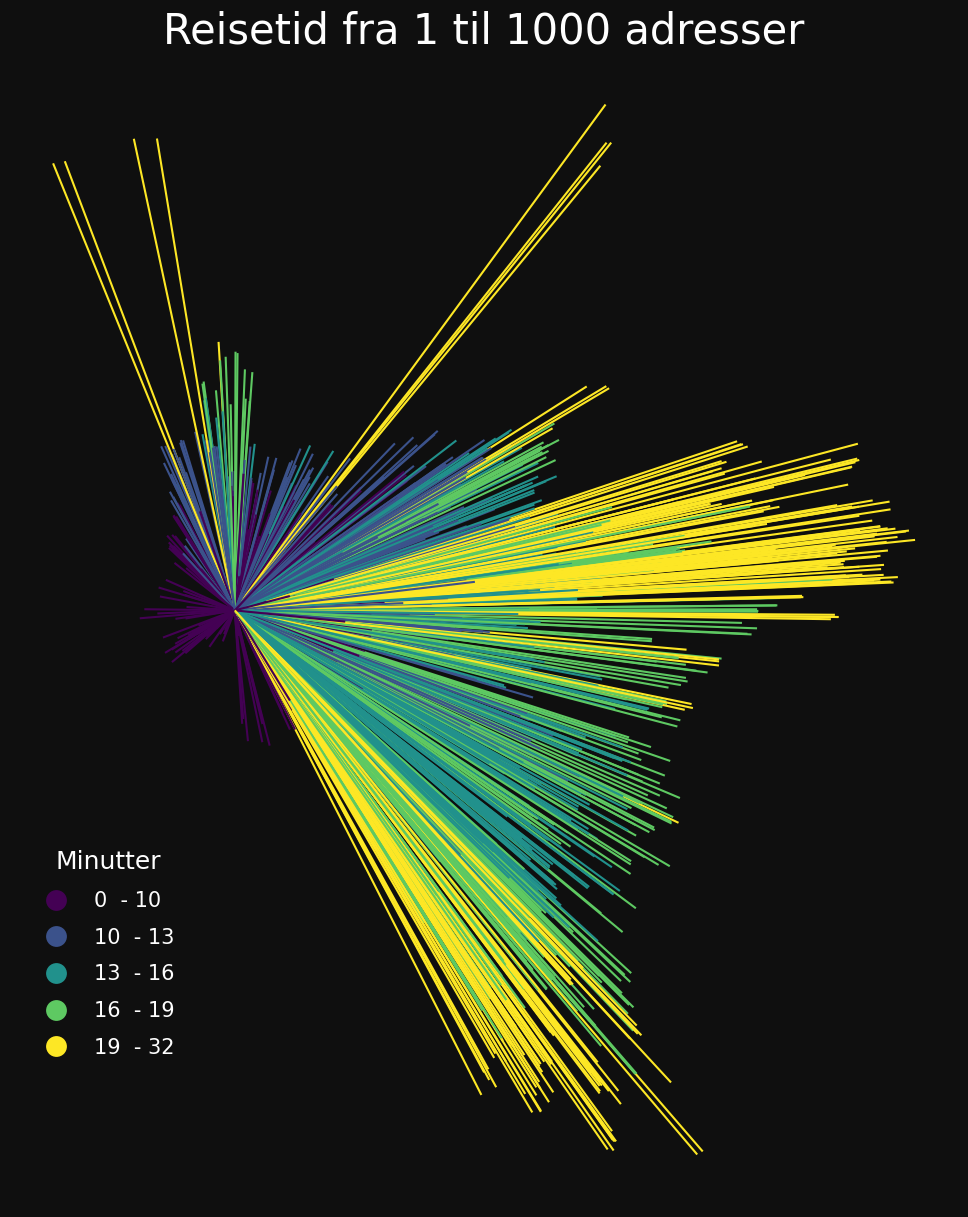

In [25]:
od = nwa.od_cost_matrix(
    origins.sample(1),
    destinations,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=15)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.legend.title = "Minutter"
m.scheme = "quantiles"
m.plot()

Sjekke loggen:

In [26]:
nwa.log

,endtime,minutes_elapsed,method,origins_count,destinations_count,percent_missing,cost_mean,percent_bidirectional
0,2024-03-11 14:43:42,0.4,get_route,1,1,0.0000,5.748210,87
1,2024-03-11 14:44:10,0.5,get_route,1,1,0.0000,4.818508,87
2,2024-03-11 14:48:07,4.0,od_cost_matrix,1000,1000,0.0999,15.674219,87
3,2024-03-11 14:50:15,2.1,od_cost_matrix,1,1000,0.0000,14.705855,87
